In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
from os import listdir

import numpy as np
# import matplotlib.colors as mcolors

## Load donor responses file (Goal Standard)

In [2]:
target = pd.read_csv('../1)cured_at_the_end_time_point.csv')[['donorID']]
target.replace('http://www.project-improvit.de/Donor/', 'Donor:', regex=True, inplace=True)
display(target.shape, target.head(2))

(14, 1)

,donorID
0,Donor:HBsRE_11
1,Donor:HBsRE_14


In [3]:
def load_cluster(cluster_addres, n_cls):
    cluster_list = []
    for i in range(n_cls):
        cls = cluster_addres + 'cluster-' + str(i) + '.txt'
        c_i = pd.read_csv(cls, delimiter=",", header=None)
        c_i.columns = ['o']
        cluster_list.append(c_i)
    return cluster_list

In [4]:
def get_num_pair(n):
    return n*(n-1)/2

def intersection(lst1, lst2): 
    return set(lst1).intersection(lst2)

## Category-based Score 𝒞(C)

In [5]:
def category_based_score(cls_algorithm, cls_measure, target):
    avg_category_score = []
    for m in cls_algorithm:
        path = cls_measure+m+'/clusters/'
        onlyfiles = [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
        num_cls = len(onlyfiles)
        clusters_algorithm = load_cluster(path, num_cls)
        category_score = []
        for cls in clusters_algorithm:
            list_cls = cls.o.to_list()
            if len(list_cls)==1:
                category_score.append(0)
                continue
            pair_sto = get_num_pair(len(list_cls))

            sto_intersected = intersection(list_cls, target.donorID.to_list())
            pair_sto_intersected = get_num_pair(len(sto_intersected))
            sum_partial=pair_sto_intersected/pair_sto
            complement = len(list_cls) - len(sto_intersected)
            pair_complement = get_num_pair(complement)
            sum_partial+=pair_complement/pair_sto
            category_score.append(sum_partial)

        avg_category_score.append(sum(category_score) / len(category_score))
#     avg_category_score = [ round(elem, 2) for elem in avg_category_score ]
    return avg_category_score

# Jaccard Index

In [6]:
def jaccard_index(cls_algorithm, cls_measure, target):
    pair_g1 = get_num_pair(len(target.donorID.to_list())) # denominator 2
    pair_g2 = get_num_pair(87 - len(target.donorID.to_list())) # denominator 2
    avg_jaccard_index = []
    for m in cls_algorithm:
        path = cls_measure+m+'/clusters/'
        onlyfiles = [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
        num_cls = len(onlyfiles)
        clusters_algorithm = load_cluster(path, num_cls)
        jaccard_index = []
        for cls in clusters_algorithm:
            list_cls = cls.o.to_list()
            if len(list_cls)==1:
                jaccard_index.append(0)
                continue
            pair_c1 = get_num_pair(len(list_cls)) # denominator 1

            entity_intersected = intersection(list_cls, target.donorID.to_list())
            pair_sto_intersected = get_num_pair(len(entity_intersected)) # numerator
            sum_partial=pair_sto_intersected/(pair_c1 + pair_g1 - (2*pair_sto_intersected))

            complement = len(list_cls) - len(entity_intersected)
            pair_complement = get_num_pair(complement)
            sum_partial+=pair_complement/(pair_c1 + pair_g2 - (2*pair_complement))
            jaccard_index.append(sum_partial)

        avg_jaccard_index.append(sum(jaccard_index) / len(jaccard_index))
#     avg_jaccard_index = [ round(elem, 2) for elem in avg_jaccard_index]
    return avg_jaccard_index

In [7]:
cls_algorithm = ['SemEP', 'METIS', 'Kmeans']

cls_measure = '../PatternDetection/clusteringMeasures/HyAI_Baseline/relationalData/'
baseline_category = category_based_score(cls_algorithm, cls_measure, target)
baseline_jaccard = jaccard_index(cls_algorithm, cls_measure, target)

cls_measure = '../PatternDetection/clusteringMeasures/HyAI_Baseline/RESCAL/'
hyAI_category = category_based_score(cls_algorithm, cls_measure, target)
hyAI_jaccard = jaccard_index(cls_algorithm, cls_measure, target)

# === adding for categorical flow-cytometry parameter ===
cls_measure = '../PatternDetection/clusteringMeasures/RESCAL/'
hyAI_enhanced_category = category_based_score(cls_algorithm, cls_measure, target)
hyAI_enhanced_jaccard = jaccard_index(cls_algorithm, cls_measure, target)
print(baseline_category, hyAI_category, hyAI_enhanced_category)
print(baseline_jaccard, hyAI_jaccard, hyAI_enhanced_jaccard)

[0.4489087301587301, 0.7124999999999999, 0.5453869047619048] [0.7283046410953388, 0.7235729386892178, 0.8461261261261261] [0.7801696020874103, 0.7274992449411054, 0.7762794406630023]
[0.01604914562492481, 0.0050275660539012505, 0.00940105663444549] [0.3139883531290635, 0.30881569161084366, 0.5547898427860901] [0.5461673519613434, 0.3179808040606875, 0.5758481315139777]


In [8]:
def plot_accuracy(plot_metrics, path, metric):
    # set width of bar
    barWidth = 0.03
    # set height of bar
    bars1 = list(plot_metrics.Baseline.values)
    bars2 = list(plot_metrics.HyAI.values)
    bars3 = list(plot_metrics['HyAI Enhanced'].values)
    

    # Set position of bar on X axis
    max_axis = len(bars1) * 0.15
    r1 = np.arange(0, max_axis, 0.15, float)
    #r1 = [0, 0.35, 0.7, 1.05, 1.4]
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, bars1, color='#264653', width=barWidth,
            edgecolor='white', label='Baseline')
    plt.bar(r2, bars2, color='#2A9D8F', width=barWidth,
            edgecolor='white', label='${HyAI}$')
    plt.bar(r3, bars3, color='#E9C46A', width=barWidth,
            edgecolor='white', label='${HyAI}$ Enhanced')

    # Add xticks on the middle of the group bars
    plt.ylim(0, 1)
    y1 = np.arange(0, 1.1, 0.1, float)
    plt.yticks(y1)
    model = list(plot_metrics.algorithm.values)
    plt.xticks([x + 0.025 for x in r1], model, fontsize=14) #, rotation='vertical'
    plt.title(metric, fontsize=14)
#     for i, v in enumerate(y):
#         plt.text(xlocs[i], v, str(v), fontsize= 16, ha='center')
    for i, v in enumerate(bars1):
        plt.text(r1[i], v+0.01, str(v), color='black', fontsize='medium', ha='center')
    for i, v in enumerate(bars2):
        plt.text(r2[i], v+0.01, str(v), color='black', fontsize='medium', ha='center')
    for i, v in enumerate(bars3):
        plt.text(r3[i], v+0.01, str(v), color='black', fontsize='medium', ha='center')


    # Create legend & Show graphic
    legend = plt.legend(loc='upper left', shadow=False, fontsize='medium', ncol=3, framealpha=0.5) # loc='upper right', 
    #plt.savefig(path + metric + ".png", format='png', bbox_inches='tight', dpi=300)
    plt.savefig(path + ".pdf", format='pdf', bbox_inches='tight')
    plt.show()

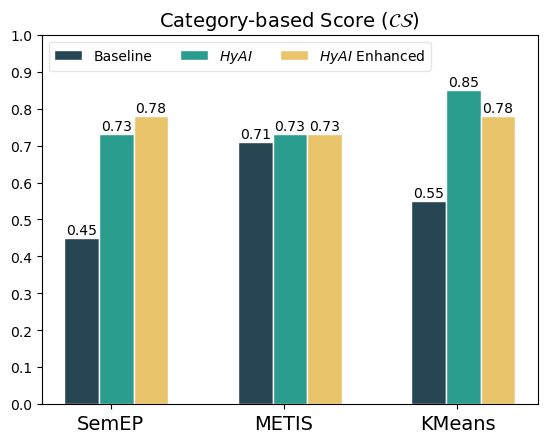

In [9]:
plot_metrics = pd.DataFrame(columns=['algorithm', 'HyAI', 'Baseline', 'HyAI Enhanced'])
plot_metrics.loc[1] = ['SemEP', 0.73, 0.45, 0.78]
plot_metrics.loc[2] = ['METIS', 0.73, 0.71, 0.73]
plot_metrics.loc[3] = ['KMeans', 0.85, 0.55, 0.78]
plot_accuracy(plot_metrics, 'GoldStandard/Category_Based_Score_Enhanced', 'Category-based Score ($\mathcal{CS}$)')

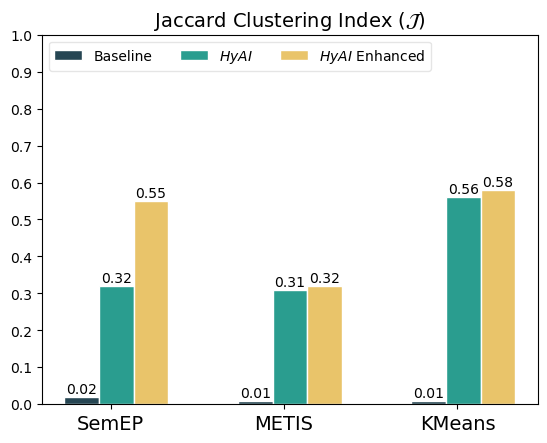

In [10]:
plot_metrics = pd.DataFrame(columns=['algorithm', 'HyAI', 'Baseline', 'HyAI Enhanced'])
plot_metrics.loc[1] = ['SemEP', 0.32, 0.02, 0.55]
plot_metrics.loc[2] = ['METIS', 0.31, 0.01, 0.32]
plot_metrics.loc[3] = ['KMeans', 0.56, 0.01, 0.58]
plot_accuracy(plot_metrics, 'GoldStandard/JaccardClusteringIndexEnhanced', 'Jaccard Clustering Index ($\mathcal{J}$)')